## 1. Introduction

The MNIST dataset, a classic in the field of computer vision, serves as a benchmark for various classification algorithms. Since its release in 1999, it has been extensively used to test and compare machine learning models. This project aims to build and optimize a deep learning model capable of recognizing handwritten digits using the MNIST dataset. I explored and implemented two different architectures: a custom Convolutional Neural Network (CNN) and a transfer learning approach using ResNet-50.


In this part, I import the necessary libraries and load the dataset.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
# Load the data
train_data = pd.read_csv('./data/train.csv')
test_data = pd.read_csv('./data/test.csv')

print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")

Train data shape: (42000, 785)
Test data shape: (28000, 784)


## 2. Data Exploration and Preprocessing

### 2.1 Data Description

The dataset consists of grayscale images of handwritten digits (0-9) of size 28x28 pixels. The training set contains 42,000 images labeled with the corresponding digit, while the test set contains 28,000 unlabeled images. 


### 2.2 Exploratory Data Analysis (EDA)

To understand the distribution and characteristics of the dataset, we performed exploratory data analysis:

- **Sample Images:** Visualized a set of sample images from the training data to observe the variations in handwriting.
- **Label Distribution:** Examined the distribution of digit labels to ensure that the dataset is balanced.


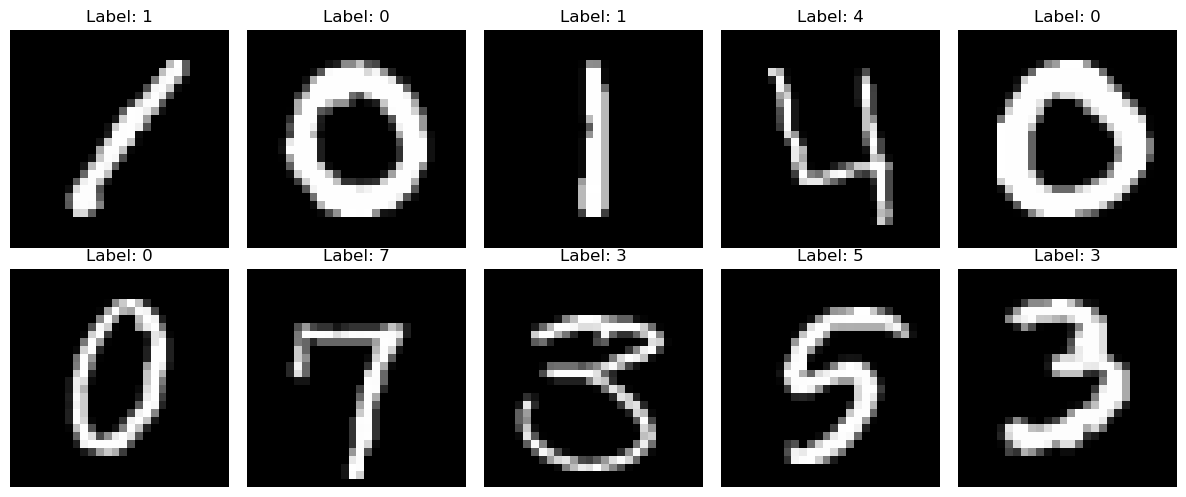

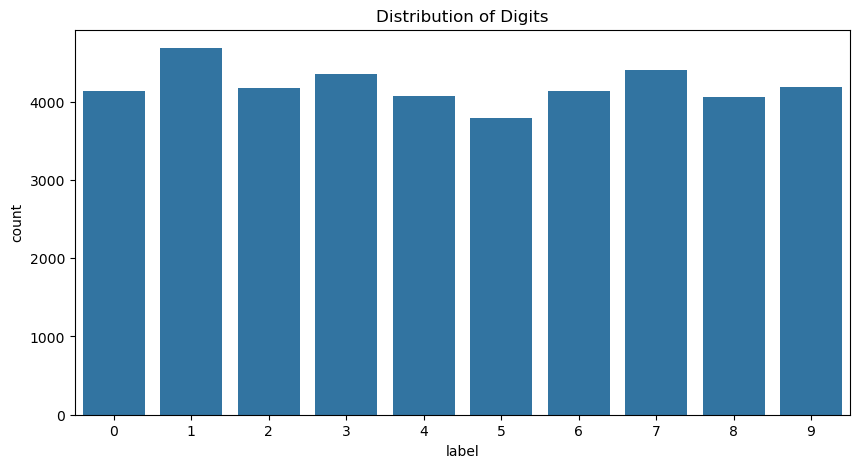

In [3]:
# Display sample images
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flatten()):
    img = train_data.iloc[i, 1:].values.reshape(28, 28)
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Label: {train_data.iloc[i, 0]}")
    ax.axis('off')
plt.tight_layout()
plt.show()

# Distribution of digits
plt.figure(figsize=(10, 5))
sns.countplot(x=train_data['label'])
plt.title('Distribution of Digits')
plt.show()

## 3. Model Architectures



In [4]:
device = torch.device("mps" if torch.backends.mps.is_built() else "cpu")

class MNISTDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image = self.dataframe.iloc[idx, 1:].values.astype(np.uint8).reshape(28, 28, 1)
        label = self.dataframe.iloc[idx, 0]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Data Transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Split the data
train_df, val_df = train_test_split(train_data, test_size=0.2, random_state=42)

# Create datasets and dataloaders
train_dataset = MNISTDataset(train_df, transform=transform)
val_dataset = MNISTDataset(val_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=0)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")

Number of training samples: 33600
Number of validation samples: 8400


### 3.1 Convolutional Neural Network (CNN)

We implemented a custom CNN architecture consisting of three convolutional layers followed by fully connected layers. This network is designed to extract spatial features from the images and predict the corresponding digit.

**Key Components:**

- Convolutional layers with ReLU activation
- MaxPooling layers for downsampling
- Dropout layer to prevent overfitting
- Fully connected layers for final classification

### 3.2 ResNet-50 Transfer Learning

To leverage the power of pre-trained models, we used ResNet-50 with pre-trained weights on ImageNet. The initial convolutional layer was modified to accept single-channel images. The final fully connected layer was adjusted to output predictions for the 10 digit classes.

In [5]:
class CNN(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 4 * 4, 64)
        self.fc2 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 64 * 4 * 4)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

class RESNET50(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(RESNET50, self).__init__()
        self.resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_ftrs, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.resnet(x)

### 4.2 Results and Analysis

After tuning, the best-performing model was selected based on validation accuracy. The models were evaluated on the validation set, and the results were visualized using confusion matrices to understand the model’s performance.

**Final Validation Accuracy:**

- CNN: Best accuracy value
- ResNet-50: Best accuracy value

In [ ]:
import optuna

class PyTorchModel:
    def __init__(self, model_class, **kwargs):
        self.model = model_class(**kwargs)
        self.model.to(device)

    def fit(self, train_loader, val_loader, num_epochs, learning_rate, trial=None):
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)

        patience = 3
        best_val_acc = 0
        patience_counter = 0

        for epoch in range(num_epochs):
            self.model.train()
            train_loss = 0.0
            for inputs, targets in train_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
            
                train_loss += loss.item()
            
            # Validation
            val_loss, val_acc = self.evaluate_model(val_loader, criterion)

            print(f'Epoch {epoch+1}/{num_epochs}')
            print(f'Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')
        
            # Early stopping check
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    break
            
            if trial:
                trial.report(val_acc, epoch)
                if trial.should_prune():
                    raise optuna.TrialPruned()
        
        return val_loss, best_val_acc
    
    def evaluate_model(self, dataloader, criterion):
        self.model.eval()
        val_loss = 0.0
        all_preds = []
        all_targets = []
        
        with torch.no_grad():
            for inputs, targets in dataloader:
                inputs, targets = inputs.to(device), targets.to(device)
                
                outputs = self.model(inputs)
                loss = criterion(outputs, targets)
                
                val_loss += loss.item() * inputs.size(0)
                
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_targets.extend(targets.cpu().numpy())
        
        val_loss = val_loss / len(dataloader.dataset)
        accuracy = accuracy_score(all_targets, all_preds)
        
        return val_loss, accuracy

def objective(trial, model_class, train_loader, val_loader):
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True) 
    num_epochs = trial.suggest_int('num_epochs', 6, 20)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.6)

    model = PyTorchModel(model_class, dropout_rate=dropout_rate)
    val_loss, val_acc = model.fit(train_loader, val_loader, num_epochs, learning_rate, trial)

    return val_acc

In [10]:
def run_study(model_class, n_trials=6):
    study = optuna.create_study(direction='maximize', sampler = optuna.samplers.TPESampler())
    study.optimize(lambda trial: objective(trial, model_class, train_loader, val_loader), n_trials=n_trials)
    
    print(f"Best trial:")
    trial = study.best_trial
    print(f"  Value: {trial.value}")
    print("  Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")
    
    return study

# Run hyperparameter tuning for SimpleCNN
simple_cnn_study = run_study(CNN)

# Run hyperparameter tuning for TransferLearningModel
simple_resnet_study = run_study(RESNET50)

[I 2024-08-18 13:49:19,322] A new study created in memory with name: no-name-a4523424-7242-4b50-abc4-a22c688f0b87


Epoch 1/9
Train Loss: 365.1588, Val Loss: 0.1631, Val Accuracy: 0.9530
Epoch 2/9
Train Loss: 100.5987, Val Loss: 0.1002, Val Accuracy: 0.9704
Epoch 3/9
Train Loss: 71.9792, Val Loss: 0.0813, Val Accuracy: 0.9749
Epoch 4/9
Train Loss: 58.6558, Val Loss: 0.0712, Val Accuracy: 0.9767
Epoch 5/9
Train Loss: 50.2701, Val Loss: 0.0569, Val Accuracy: 0.9810
Epoch 6/9
Train Loss: 45.5883, Val Loss: 0.0575, Val Accuracy: 0.9817
Epoch 7/9
Train Loss: 38.8361, Val Loss: 0.0486, Val Accuracy: 0.9844
Epoch 8/9
Train Loss: 34.7613, Val Loss: 0.0505, Val Accuracy: 0.9836


[I 2024-08-18 13:50:45,857] Trial 0 finished with value: 0.9867857142857143 and parameters: {'learning_rate': 0.0002171490593280088, 'num_epochs': 9, 'dropout_rate': 0.31513815572846604}. Best is trial 0 with value: 0.9867857142857143.


Epoch 9/9
Train Loss: 32.2736, Val Loss: 0.0431, Val Accuracy: 0.9868
Epoch 1/11
Train Loss: 338.7061, Val Loss: 0.0904, Val Accuracy: 0.9749
Epoch 2/11
Train Loss: 172.2668, Val Loss: 0.0627, Val Accuracy: 0.9821
Epoch 3/11
Train Loss: 128.0778, Val Loss: 0.0567, Val Accuracy: 0.9827
Epoch 4/11
Train Loss: 104.9303, Val Loss: 0.0493, Val Accuracy: 0.9858
Epoch 5/11
Train Loss: 80.4993, Val Loss: 0.0451, Val Accuracy: 0.9875
Epoch 6/11
Train Loss: 75.9564, Val Loss: 0.0497, Val Accuracy: 0.9865
Epoch 7/11
Train Loss: 68.6594, Val Loss: 0.0474, Val Accuracy: 0.9864
Epoch 8/11
Train Loss: 58.2463, Val Loss: 0.0484, Val Accuracy: 0.9889
Epoch 9/11
Train Loss: 49.9545, Val Loss: 0.0433, Val Accuracy: 0.9888
Epoch 10/11
Train Loss: 43.7624, Val Loss: 0.0451, Val Accuracy: 0.9900


[I 2024-08-18 13:52:30,662] Trial 1 finished with value: 0.99 and parameters: {'learning_rate': 0.002165491785773899, 'num_epochs': 11, 'dropout_rate': 0.5991974596849353}. Best is trial 1 with value: 0.99.


Epoch 11/11
Train Loss: 42.3006, Val Loss: 0.0552, Val Accuracy: 0.9861
Epoch 1/12
Train Loss: 982.0395, Val Loss: 0.9523, Val Accuracy: 0.7870
Epoch 2/12
Train Loss: 417.3262, Val Loss: 0.4310, Val Accuracy: 0.8957
Epoch 3/12
Train Loss: 269.3271, Val Loss: 0.2973, Val Accuracy: 0.9256
Epoch 4/12
Train Loss: 207.9540, Val Loss: 0.2327, Val Accuracy: 0.9362
Epoch 5/12
Train Loss: 173.9589, Val Loss: 0.2002, Val Accuracy: 0.9440
Epoch 6/12
Train Loss: 151.2920, Val Loss: 0.1771, Val Accuracy: 0.9505
Epoch 7/12
Train Loss: 135.7050, Val Loss: 0.1568, Val Accuracy: 0.9567
Epoch 8/12
Train Loss: 123.6109, Val Loss: 0.1427, Val Accuracy: 0.9592
Epoch 9/12
Train Loss: 113.4291, Val Loss: 0.1309, Val Accuracy: 0.9620
Epoch 10/12
Train Loss: 105.3994, Val Loss: 0.1270, Val Accuracy: 0.9619
Epoch 11/12
Train Loss: 97.5340, Val Loss: 0.1168, Val Accuracy: 0.9664


[I 2024-08-18 13:54:25,985] Trial 2 finished with value: 0.9666666666666667 and parameters: {'learning_rate': 2.7869981035961384e-05, 'num_epochs': 12, 'dropout_rate': 0.40378117403474967}. Best is trial 1 with value: 0.99.


Epoch 12/12
Train Loss: 92.5569, Val Loss: 0.1116, Val Accuracy: 0.9667
Epoch 1/15
Train Loss: 168.1394, Val Loss: 0.0659, Val Accuracy: 0.9817
Epoch 2/15
Train Loss: 63.8837, Val Loss: 0.0573, Val Accuracy: 0.9818
Epoch 3/15
Train Loss: 52.4548, Val Loss: 0.0557, Val Accuracy: 0.9836
Epoch 4/15
Train Loss: 44.4501, Val Loss: 0.0525, Val Accuracy: 0.9845
Epoch 5/15
Train Loss: 39.0887, Val Loss: 0.0461, Val Accuracy: 0.9879
Epoch 6/15
Train Loss: 36.2089, Val Loss: 0.0386, Val Accuracy: 0.9880
Epoch 7/15
Train Loss: 34.4078, Val Loss: 0.0428, Val Accuracy: 0.9883
Epoch 8/15
Train Loss: 30.1450, Val Loss: 0.0365, Val Accuracy: 0.9901
Epoch 9/15
Train Loss: 27.9120, Val Loss: 0.0446, Val Accuracy: 0.9880
Epoch 10/15
Train Loss: 25.2238, Val Loss: 0.0504, Val Accuracy: 0.9894


[I 2024-08-18 13:56:11,566] Trial 3 finished with value: 0.9901190476190476 and parameters: {'learning_rate': 0.0036021340022326645, 'num_epochs': 15, 'dropout_rate': 0.406233937782839}. Best is trial 3 with value: 0.9901190476190476.


Epoch 11/15
Train Loss: 27.8477, Val Loss: 0.0481, Val Accuracy: 0.9881
Epoch 1/15
Train Loss: 257.3447, Val Loss: 0.1268, Val Accuracy: 0.9631
Epoch 2/15
Train Loss: 63.8483, Val Loss: 0.0824, Val Accuracy: 0.9742
Epoch 3/15
Train Loss: 44.0088, Val Loss: 0.0650, Val Accuracy: 0.9805
Epoch 4/15
Train Loss: 35.8969, Val Loss: 0.0535, Val Accuracy: 0.9826
Epoch 5/15
Train Loss: 29.2878, Val Loss: 0.0529, Val Accuracy: 0.9840
Epoch 6/15
Train Loss: 24.6109, Val Loss: 0.0421, Val Accuracy: 0.9863
Epoch 7/15
Train Loss: 21.2555, Val Loss: 0.0526, Val Accuracy: 0.9837
Epoch 8/15
Train Loss: 19.3996, Val Loss: 0.0381, Val Accuracy: 0.9875
Epoch 9/15
Train Loss: 16.8270, Val Loss: 0.0413, Val Accuracy: 0.9876
Epoch 10/15
Train Loss: 14.8848, Val Loss: 0.0375, Val Accuracy: 0.9888
Epoch 11/15
Train Loss: 13.4652, Val Loss: 0.0338, Val Accuracy: 0.9890
Epoch 12/15
Train Loss: 11.5638, Val Loss: 0.0400, Val Accuracy: 0.9890
Epoch 13/15
Train Loss: 10.4177, Val Loss: 0.0389, Val Accuracy: 0.9887


[I 2024-08-18 13:58:34,624] Trial 4 finished with value: 0.9909523809523809 and parameters: {'learning_rate': 0.00040747637339621264, 'num_epochs': 15, 'dropout_rate': 0.17324038763858832}. Best is trial 4 with value: 0.9909523809523809.


Epoch 15/15
Train Loss: 9.0936, Val Loss: 0.0334, Val Accuracy: 0.9910
Epoch 1/11
Train Loss: 263.4098, Val Loss: 0.0881, Val Accuracy: 0.9730
Epoch 2/11
Train Loss: 102.6346, Val Loss: 0.0650, Val Accuracy: 0.9796
Epoch 3/11
Train Loss: 77.4747, Val Loss: 0.0574, Val Accuracy: 0.9830
Epoch 4/11
Train Loss: 64.7278, Val Loss: 0.0425, Val Accuracy: 0.9871
Epoch 5/11
Train Loss: 52.6761, Val Loss: 0.0463, Val Accuracy: 0.9857
Epoch 6/11
Train Loss: 47.8147, Val Loss: 0.0425, Val Accuracy: 0.9862


[I 2024-08-18 13:59:41,392] Trial 5 finished with value: 0.9871428571428571 and parameters: {'learning_rate': 0.0022098021269977724, 'num_epochs': 11, 'dropout_rate': 0.5111212638351136}. Best is trial 4 with value: 0.9909523809523809.
[I 2024-08-18 13:59:41,393] A new study created in memory with name: no-name-44854d28-7973-452a-845a-cd86852a5349


Epoch 7/11
Train Loss: 42.0927, Val Loss: 0.0461, Val Accuracy: 0.9845
Best trial:
  Value: 0.9909523809523809
  Params: 
    learning_rate: 0.00040747637339621264
    num_epochs: 15
    dropout_rate: 0.17324038763858832
Epoch 1/13
Train Loss: 171.2898, Val Loss: 0.0846, Val Accuracy: 0.9779
Epoch 2/13
Train Loss: 63.3701, Val Loss: 0.0568, Val Accuracy: 0.9846
Epoch 3/13
Train Loss: 40.7941, Val Loss: 0.0607, Val Accuracy: 0.9839
Epoch 4/13
Train Loss: 51.2295, Val Loss: 0.0568, Val Accuracy: 0.9855
Epoch 5/13
Train Loss: 29.9815, Val Loss: 0.0549, Val Accuracy: 0.9850
Epoch 6/13
Train Loss: 28.7469, Val Loss: 0.0553, Val Accuracy: 0.9858
Epoch 7/13
Train Loss: 31.2102, Val Loss: 0.0591, Val Accuracy: 0.9843
Epoch 8/13
Train Loss: 23.6274, Val Loss: 0.0351, Val Accuracy: 0.9915
Epoch 9/13
Train Loss: 28.6074, Val Loss: 0.0570, Val Accuracy: 0.9851
Epoch 10/13
Train Loss: 30.5923, Val Loss: 0.0605, Val Accuracy: 0.9848


[I 2024-08-18 14:08:00,615] Trial 0 finished with value: 0.991547619047619 and parameters: {'learning_rate': 0.0005346176836492912, 'num_epochs': 13, 'dropout_rate': 0.5672941647020431}. Best is trial 0 with value: 0.991547619047619.


Epoch 11/13
Train Loss: 27.5240, Val Loss: 0.0401, Val Accuracy: 0.9905
Epoch 1/13
Train Loss: 309.7808, Val Loss: 0.1324, Val Accuracy: 0.9608
Epoch 2/13
Train Loss: 65.7214, Val Loss: 0.0838, Val Accuracy: 0.9758
Epoch 3/13
Train Loss: 34.3433, Val Loss: 0.0695, Val Accuracy: 0.9796
Epoch 4/13
Train Loss: 23.9523, Val Loss: 0.0680, Val Accuracy: 0.9800
Epoch 5/13
Train Loss: 19.1293, Val Loss: 0.0589, Val Accuracy: 0.9833
Epoch 6/13
Train Loss: 13.0361, Val Loss: 0.0655, Val Accuracy: 0.9815
Epoch 7/13
Train Loss: 12.9246, Val Loss: 0.0540, Val Accuracy: 0.9856
Epoch 8/13
Train Loss: 11.8770, Val Loss: 0.0553, Val Accuracy: 0.9864
Epoch 9/13
Train Loss: 8.3105, Val Loss: 0.0616, Val Accuracy: 0.9844
Epoch 10/13
Train Loss: 8.7023, Val Loss: 0.0626, Val Accuracy: 0.9836


[I 2024-08-18 14:16:20,822] Trial 1 finished with value: 0.9864285714285714 and parameters: {'learning_rate': 4.7025139893986394e-05, 'num_epochs': 13, 'dropout_rate': 0.23099090689811344}. Best is trial 0 with value: 0.991547619047619.


Epoch 11/13
Train Loss: 10.9721, Val Loss: 0.0595, Val Accuracy: 0.9843
Epoch 1/11
Train Loss: 133.0616, Val Loss: 0.0711, Val Accuracy: 0.9810
Epoch 2/11
Train Loss: 61.1063, Val Loss: 0.0554, Val Accuracy: 0.9843
Epoch 3/11
Train Loss: 43.8029, Val Loss: 0.0835, Val Accuracy: 0.9780
Epoch 4/11
Train Loss: 42.5137, Val Loss: 0.0957, Val Accuracy: 0.9748
Epoch 5/11
Train Loss: 28.0351, Val Loss: 0.0503, Val Accuracy: 0.9881
Epoch 6/11
Train Loss: 22.6350, Val Loss: 0.0424, Val Accuracy: 0.9887
Epoch 7/11
Train Loss: 23.8475, Val Loss: 0.0445, Val Accuracy: 0.9885
Epoch 8/11
Train Loss: 21.1241, Val Loss: 0.0497, Val Accuracy: 0.9869


[I 2024-08-18 14:23:12,406] Trial 2 finished with value: 0.9886904761904762 and parameters: {'learning_rate': 0.0007238881607440251, 'num_epochs': 11, 'dropout_rate': 0.34034528906757233}. Best is trial 0 with value: 0.991547619047619.


Epoch 9/11
Train Loss: 21.8818, Val Loss: 0.0422, Val Accuracy: 0.9879
Epoch 1/11
Train Loss: 1459.3276, Val Loss: 2.3050, Val Accuracy: 0.1063
Epoch 2/11
Train Loss: 1244.3208, Val Loss: 2.3091, Val Accuracy: 0.1063
Epoch 3/11
Train Loss: 1212.0384, Val Loss: 2.3044, Val Accuracy: 0.1063


[I 2024-08-18 14:26:14,230] Trial 3 finished with value: 0.10630952380952381 and parameters: {'learning_rate': 0.08772981721605143, 'num_epochs': 11, 'dropout_rate': 0.104554459419434}. Best is trial 0 with value: 0.991547619047619.


Epoch 4/11
Train Loss: 1212.8186, Val Loss: 2.3088, Val Accuracy: 0.1063
Epoch 1/8
Train Loss: 620.6589, Val Loss: 2.7738, Val Accuracy: 0.4698
Epoch 2/8
Train Loss: 548.5173, Val Loss: 0.2908, Val Accuracy: 0.9194
Epoch 3/8
Train Loss: 177.0122, Val Loss: 0.5156, Val Accuracy: 0.9074
Epoch 4/8
Train Loss: 110.1389, Val Loss: 0.1380, Val Accuracy: 0.9670
Epoch 5/8
Train Loss: 78.7376, Val Loss: 0.1300, Val Accuracy: 0.9671
Epoch 6/8
Train Loss: 83.4655, Val Loss: 1.2121, Val Accuracy: 0.7567
Epoch 7/8
Train Loss: 213.6609, Val Loss: 0.1639, Val Accuracy: 0.9457


[I 2024-08-18 14:32:14,164] Trial 4 finished with value: 0.974047619047619 and parameters: {'learning_rate': 0.009701361032898781, 'num_epochs': 8, 'dropout_rate': 0.3212202113538253}. Best is trial 0 with value: 0.991547619047619.


Epoch 8/8
Train Loss: 91.7857, Val Loss: 0.1095, Val Accuracy: 0.9740
Epoch 1/12
Train Loss: 270.6986, Val Loss: 0.1216, Val Accuracy: 0.9650


[I 2024-08-18 14:33:45,030] Trial 5 pruned. 


Epoch 2/12
Train Loss: 55.9142, Val Loss: 0.0880, Val Accuracy: 0.9748
Best trial:
  Value: 0.991547619047619
  Params: 
    learning_rate: 0.0005346176836492912
    num_epochs: 13
    dropout_rate: 0.5672941647020431


/var/folders/tt/bg81xkx10n788vrk6hd47xs80000gn/T/ipykernel_1750/3070403149.py:5: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


<Figure size 1600x1200 with 0 Axes>

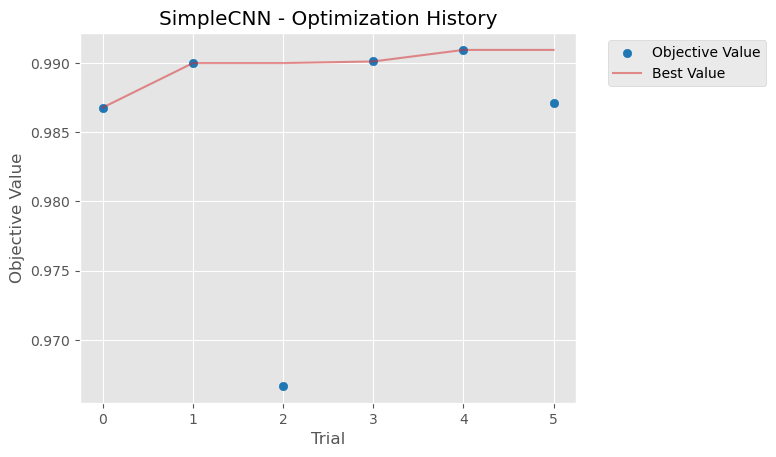

/var/folders/tt/bg81xkx10n788vrk6hd47xs80000gn/T/ipykernel_1750/3070403149.py:5: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


<Figure size 1600x1200 with 0 Axes>

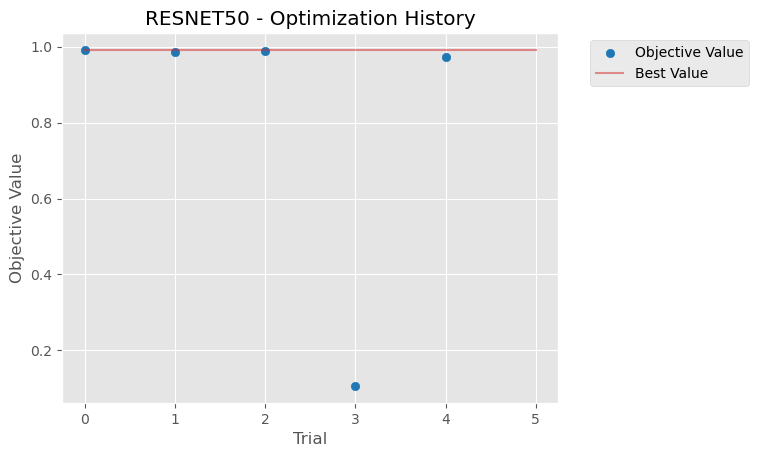

In [73]:
def visualize_hyperparameter_tuning(study, model_name):
    plt.figure(figsize=(16, 12))

    # Plot optimization history
    optuna.visualization.matplotlib.plot_optimization_history(study)
    plt.title(f"{model_name} - Optimization History")

    plt.show()

visualize_hyperparameter_tuning(simple_cnn_study, "SimpleCNN")
visualize_hyperparameter_tuning(simple_resnet_study, "RESNET50")

Best model is ResNet
Epoch 1/13
Train Loss: 170.1354, Val Loss: 0.0973, Val Accuracy: 0.9746
Epoch 2/13
Train Loss: 60.6304, Val Loss: 0.0781, Val Accuracy: 0.9796
Epoch 3/13
Train Loss: 45.9178, Val Loss: 0.0505, Val Accuracy: 0.9858
Epoch 4/13
Train Loss: 37.8074, Val Loss: 0.0588, Val Accuracy: 0.9842
Epoch 5/13
Train Loss: 40.1310, Val Loss: 0.0438, Val Accuracy: 0.9888
Epoch 6/13
Train Loss: 30.0491, Val Loss: 0.0423, Val Accuracy: 0.9893
Epoch 7/13
Train Loss: 37.6558, Val Loss: 0.0680, Val Accuracy: 0.9848
Epoch 8/13
Train Loss: 21.7640, Val Loss: 0.0436, Val Accuracy: 0.9877
Epoch 9/13
Train Loss: 26.7892, Val Loss: 0.0453, Val Accuracy: 0.9880
Best model saved to ./model/best_model.pth
Final Validation Accuracy: 0.9893


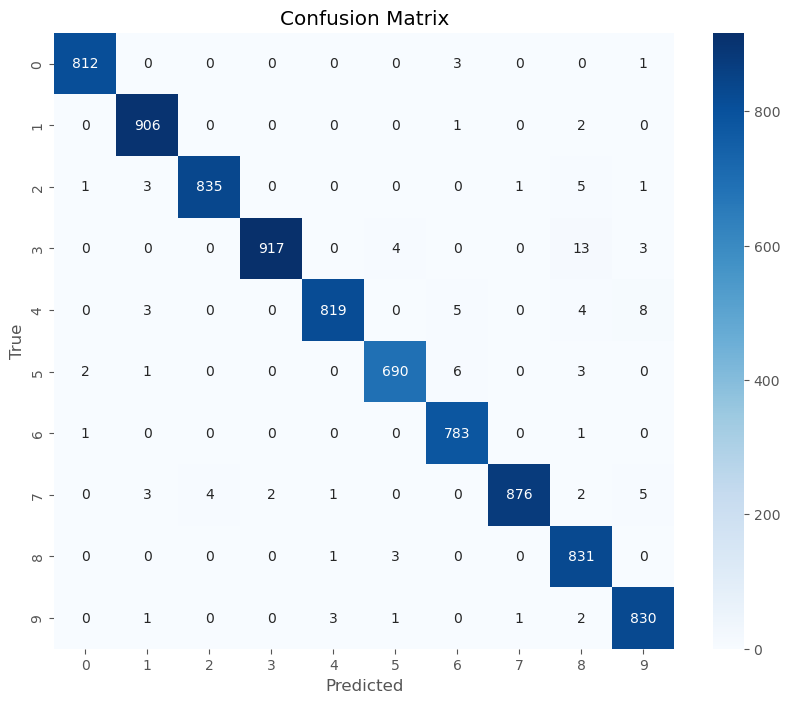

In [45]:
def train_and_evaluate(cnn_study, resnet_study, train_loader, val_loader):
    cnn_best_trial = cnn_study.best_trial
    resnet_best_trial = resnet_study.best_trial

    if cnn_best_trial.value > resnet_best_trial.value:
        print("Best model is CNN")
        best_params = cnn_best_trial.params
        best_model = PyTorchModel(CNN, dropout_rate=best_params['dropout_rate'])
    else:
        print("Best model is ResNet")
        best_params = resnet_best_trial.params
        best_model = PyTorchModel(RESNET50, dropout_rate=best_params['dropout_rate'])
    
    val_loss, val_acc = best_model.fit(
        train_loader, 
        val_loader, 
        best_params['num_epochs'], 
        best_params['learning_rate']
    )

    torch.save(best_model.model.state_dict(), os.path.join('./model', 'best_model.pth'))
    print("Best model saved to ./model/best_model.pth")

    print(f"Final Validation Accuracy: {val_acc:.4f}")
    
    # Confusion Matrix
    y_true = []
    y_pred = []
    best_model.model.eval()
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = best_model.model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(targets.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    return best_model
# Train and evaluate
best_model = train_and_evaluate(simple_cnn_study, simple_resnet_study, train_loader, val_loader)

## 5. Conclusion

This project demonstrates the application of deep learning techniques to the MNIST digit recognition task. Both a custom CNN and a ResNet-50 transfer learning model were explored. The hyperparameter tuning process played a crucial role in improving model performance. The results show that deep learning models, even with relatively simple architectures, can achieve high accuracy on handwritten digit recognition tasks.


## 6. Submission

The best-performing model was used to generate predictions for the test set. The predictions were saved in a submission file format required by Kaggle.

The submission file was successfully submitted to the Kaggle competition, and the final score was recorded. Please refer to the screenshot in the same folder for the submission details.

My GitHub repository contains the code for this project, including the data preprocessing, model implementation, and evaluation steps. The code is well-documented and organized for easy understanding and reproducibility. Feel free to explore the repository and provide feedback or suggestions for improvement. https://github.com/jinzhang01/Deep-Learning-Final.git



In [53]:
class MNISTestDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image = self.dataframe.iloc[idx].values.astype(np.float32)
        
        image = image.reshape(28, 28)
        
        if self.transform:
            image = self.transform(image)
        
        return image

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)) 
])

def create_submission(best_model, test_loader, submission_file):
    best_model.model.load_state_dict(torch.load(f"./model/best_model.pth"))
    best_model.model.eval()

    all_preds = []

    with torch.no_grad():
        for inputs in test_loader:
            inputs = inputs.to(device)
            outputs = best_model.model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())

    # Create submission DataFrame
    submission_df = pd.DataFrame({
        'ImageId': range(1, len(all_preds) + 1),
        'Label': all_preds
    })

    # Save submission file
    submission_df.to_csv(submission_file, index=False)
    print(f"Submission file saved to {submission_file}")

# Prepare test data
test_dataset = MNISTestDataset(test_data, transform=transform_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

create_submission(best_model, test_loader, './output/submission.csv')

Submission file saved to ./output/submission.csv


## 7. References

- MNIST Dataset: [http://yann.lecun.com/exdb/mnist/](http://yann.lecun.com/exdb/mnist/)
- Kaggle Digit Recognizer: [https://www.kaggle.com/c/digit-recognizer](https://www.kaggle.com/c/digit-recognizer)